CLoNe - Clustering based on local neighborhoods
---------------------------------------------------------------------------

Here are shown several examples of CLoNe on toy datasets, how to use parameters and plot the data.

1. Minimal code to run, examples on several datasets
2. Visualize the different steps of the algorithm
3. Save on time and memory by truncating the neighbour matrix
4. Finding main cluster hierarchies in dataset


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import time

import matplotlib.pyplot as mplot
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import cycle, islice

from clone import CLoNe

# colors for plotting
colors = np.array(['yellowgreen', 'Crimson', 'orange', 'mediumpurple', 'deepskyblue', 'Aquamarine', 'DarkGoldenRod',
              'Khaki', 'SteelBlue', 'Olive', 'Violet', 'DarkSeaGreen', 'RosyBrown', 'LightPink', 'DodgerBlue',
              'lightcoral', 'chocolate', 'burlywood', 'cyan', 'olivedrab', 'palegreen', 'turquoise', 'gold', 'teal',
              'hotpink', 'moccasin', 'lawngreen', 'sandybrown', 'blueviolet', 'powderblue', 'plum', 'springgreen',
              'mediumaquamarine', 'rebeccapurple', 'peru', 'lightsalmon', 'khaki', 'sienna', 'lightseagreen', 'lightcyan',
              'yellowgreen', 'Crimson', 'orange', 'mediumpurple', 'deepskyblue', 'Aquamarine', 'DarkGoldenRod',
              'Khaki', 'SteelBlue', 'Olive', 'Violet', 'DarkSeaGreen', 'RosyBrown', 'LightPink', 'DodgerBlue'])

1-Examples on toy datasets
-----------------
* Spiral
* Aggregation
* Flame
* s4
* a3

Source:
> http://cs.joensuu.fi/sipu/datasets/

> Reference:
>   P. Fränti and S. Sieranoja
>   K-means properties on six clustering benchmark datasets
>   Applied Intelligence, 48 (12), 4743-4759, December 2018
>   https://doi.org/10.1007/s10489-018-1238-7

In all examples below, clusters are shown in colored circles, outliers are shown as black crosses and cluster centers as black stars.

Minimal code to run and plot results
----

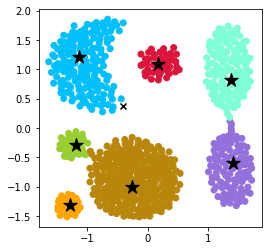

In [14]:
# Load data
with open("examples/aggregation.txt", 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
data = StandardScaler().fit_transform(data)

# Cluster
clone = CLoNe()
clone.fit(data)

# Mask for real cluster labels (!=-1) and outliers (==-1)
assigned_mask = np.where(clone.labels_ != -1)
outliers_mask = np.where(clone.labels_ == -1)

# Plot
mplot.figure(figsize=(4,4))
mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x')
mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
mplot.scatter(data[clone.centers_,0], data[clone.centers_,1], c='black', marker='*', s=200)
mplot.show()

Running CLoNe on 'spiral' dataset
Running CLoNe on 'aggregation' dataset
Running CLoNe on 'flame' dataset
Running CLoNe on 's4' dataset
Running CLoNe on 'a3' dataset


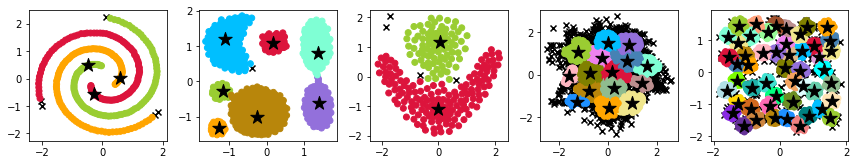

In [23]:
# More examples with different parameter value
dataset_params = {'spiral': 4, 'aggregation': 4, 'flame': 5, 's4': 2, 'a3': 1}

mplot.figure(figsize=(12,12 / len(dataset_params)))
plot_idx = 1
for dataset_name in dataset_params.keys():
    with open("examples/%s.txt"%dataset_name, 'r') as f:
        headers = next(f).split()
        data = np.array([[float(x) for x in line.split()] for line in f])
    data = StandardScaler().fit_transform(data)
    
    # Cluster
    print("Running CLoNe on '%s' dataset"%dataset_name)
    clone = CLoNe(factor_dc = dataset_params[dataset_name])
    clone.fit(data)
    
    # Plot labels on data
    mplot.subplot(1, 5, plot_idx)
    assigned_mask = np.where(clone.labels_ != -1)
    outliers_mask = np.where(clone.labels_ == -1)
    mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x')
    mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
    mplot.scatter(data[clone.centers_,0], data[clone.centers_,1], c='black', marker='*', s=200)
    mplot.gca().set_aspect('auto')
    plot_idx += 1
    
mplot.tight_layout()
mplot.show()

2-Visualize the different steps of the algorithm
----

CLoNe is a variant of "Clustering by fast search and find of density peaks" by Alex Rodriguez, Alessandro Laio, published in Science in 2014 (DOI: 10.1126/science.1242072)

It improves on the original approach thank to:
* Automated determination of cluster centers. CLoNe initially considers that all points are cluster centers, and then aims at estimating their hypothetical cluster size.
    * CLoNe first computes a growing volumetric neighbour density for each point at given intervals (10) of neighbours, and detects at which interval density changes dramatically (global neighbour threshold, gnt) (figure below, left). This happens when adding points that belong to other clusters, as the radius when computing volumetric neighbour density will increase considerably. The biggest change is detected through the coefficient of determination between every pair of successive interval (figure below, right). This value is a primer for the next step and can be interpreted as a typical cluster size for the dataset. 
    *  This value is not realistic if you have clusters of different sizes, so it is adpated for every point.  CLoNe thus computes a local density (rho) for each point using a Gaussian kernel. For each point, its local neighbour threshold (lnt) will be the amount of neighbours that can contribute substantially to its local density. In essence, for a given point 'i', adding a new neighbour to its lnt value means that it contributes to at least the current local density of point 'i' divided by gnt. lnt values can be interpreted as the hypothetical cluster size of every point if they were a cluster center (figure below, right).
    * To decide if a given point 'i' with an lnt of 45 is indeed a cluster center, CLoNe will find its nearest neighbour of higher local density (rho). If this point is beyond 45 neighbours of 'i', then 'i' is a cluster center. If that point of higher density is, e.g., the 15th neighbour of 'i', then it is not a cluster center.

* Improved speed and memory use by using a neighbour matrix from Nearest Neighbours instead of a full distance matrix
* Ability to detect cluster hierarchies in some datasets

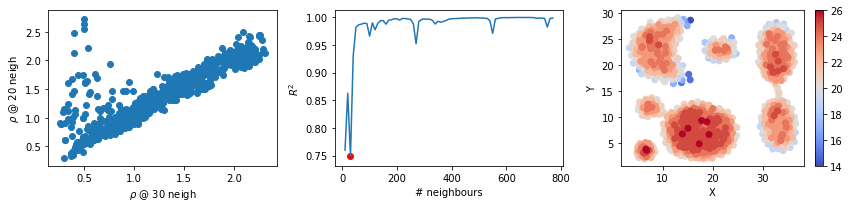

Gnt: 30, R2: 0.74931


In [16]:
dataset_name = 'aggregation'
with open("examples/%s.txt"%dataset_name, 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
    
# Cluster
clone = CLoNe(factor_dc=5)
clone.fit(data)

# Sort some values for better visualization after
arlnt = np.argsort(clone.lnt_)
s_lnts = clone.lnt_[arlnt]
s_x = data[arlnt, 0]
s_y = data[arlnt, 1]

# Plot
mplot.figure(figsize=(12,3))

# 1. Neighbour density is computed from 10-neighbour intervals and interval pairs are compared
# Here, the interval at which adding new neighbours dramatically decreases the density for many points
# Which will lead to the largest drop in the coefficient of determination in the next plot
mplot.subplot(131)
mplot.scatter(clone.neigh_density_[:, clone.gnt_idx_+1], clone.neigh_density_[:, clone.gnt_idx_])
mplot.xlabel(r"$\rho$ @ %i neigh"%(clone.neighbour_interval_*(clone.gnt_idx_+1)))
mplot.ylabel(r"$\rho$ @ %i neigh"%(clone.neighbour_interval_*clone.gnt_idx_))

# 2. Comparison between intervals is made with the coefficient of determination R2
# Minima is the general neighbour threshold, gnt
mplot.subplot(132)
n_intervals = len(clone.r2_)
intervals = np.arange(1, n_intervals+1)*clone.neighbour_interval_
mplot.plot(intervals, clone.r2_)
mplot.scatter(clone.gnt_, clone.r2_[clone.gnt_idx_], marker='o', c='red' )
mplot.xlabel("# neighbours")
mplot.ylabel(r"$R^{2}$")

# 3. gnt is adapted for every point to give the local neighbour threshold, lnt, here mapped on every data point
# Can be interpreted as the hypothetical cluster sizes
mplot.subplot(133)
mplot.scatter(s_x, s_y, c=s_lnts, cmap="coolwarm")
mplot.colorbar()
mplot.gca().set_aspect('auto')
mplot.xlabel("X")
mplot.ylabel("Y")

mplot.tight_layout()
mplot.show()

print("Gnt: %i, R2: %.5f"%(clone.gnt_, clone.r2_[clone.gnt_idx_]))

3-Save on time and memory by truncating the neighbour matrix
----
Technically, only 'gnt' neighbours need to be considered when creating the neighbour matrix using NearestNeighbours. As it is not possible to know this number beforehand, it needs to be estimated. Reducing the number of neighbours to compute by 2 is a safe approach, as it would still work in a limit case with only two clusters. You can increase this value as you see fit according to your data.

**There is no need to tweak this parameter as it will not change the quality of the partitioning. It is only used to reduce memory use and computation time for large datasets. If you set it too high, you might need to correct the value for factor_dc.**

> n_resize=1 >>> found 50 clusters in 15.236 s



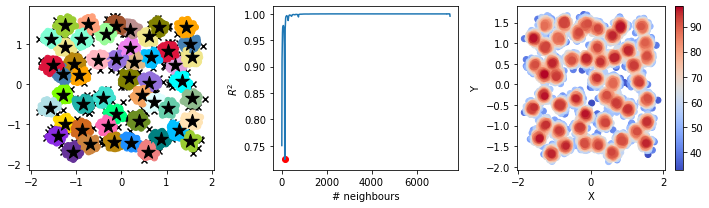

> n_resize=20 >>> found 50 clusters in 0.639 s



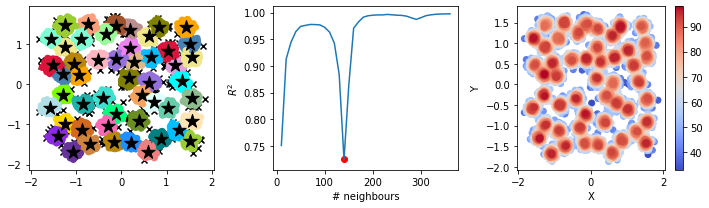

> n_resize=50 >>> found 50 clusters in 0.347 s



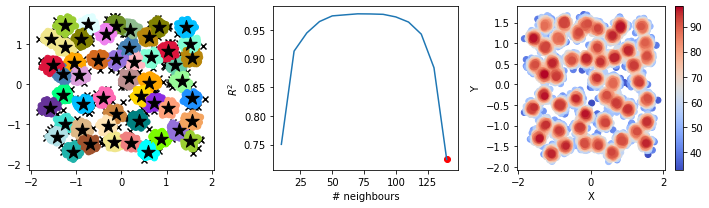

In [17]:
with open("examples/a3.txt", 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
    data = StandardScaler().fit_transform(data)
    
for n_resize in [1, 20, 50]:
    # Cluster
    t = time.time()
    clone = CLoNe(factor_dc=1, n_resize=n_resize)
    clone.fit(data)
    print("> n_resize=%i >>> found %i clusters in %.3f s\n"%(n_resize, len(clone.centers_), time.time()-t))
    
    # Mask for real cluster labels (!=-1) and outliers (==-1)
    assigned_mask = np.where(clone.labels_ != -1)
    outliers_mask = np.where(clone.labels_ == -1)
    
    # Sort some values for better visualization after
    arlnt = np.argsort(clone.lnt_)
    s_lnts = clone.lnt_[arlnt]
    s_x = data[arlnt, 0]
    s_y = data[arlnt, 1]
    
    # Plot labels and outliers
    mplot.figure(figsize=(10,3))
    mplot.subplot(131)
    mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x')
    mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
    mplot.scatter(data[clone.centers_,0], data[clone.centers_,1], c='black', marker='*', s=200)
    
    # Plot R2 and gnt
    mplot.subplot(132)
    n_intervals = len(clone.r2_)
    intervals = np.arange(1, n_intervals+1)*clone.neighbour_interval_
    mplot.plot(intervals, clone.r2_)
    mplot.scatter(clone.gnt_, clone.r2_[clone.gnt_idx_], marker='o', c='red' )
    mplot.xlabel("# neighbours")
    mplot.ylabel(r"$R^{2}$")

    # Plot local neighbour thresholds per point
    mplot.subplot(133)
    mplot.scatter(s_x, s_y, c=s_lnts, cmap="coolwarm")
    mplot.colorbar()
    mplot.gca().set_aspect('auto')
    mplot.xlabel("X")
    mplot.ylabel("Y")

    mplot.tight_layout()
    mplot.show()


4-Finding main cluster hierarchies in a dataset
---
In the R2 plot, there might be more than one drop. They might correspond to different cluser hierarchies. In the example below, we show how a quartet of spirals, each made of 3 branches, leads to two distinct cluster hierarchies.
The output of CLoNe remains the same, but with list instead of singular variables where applicable.


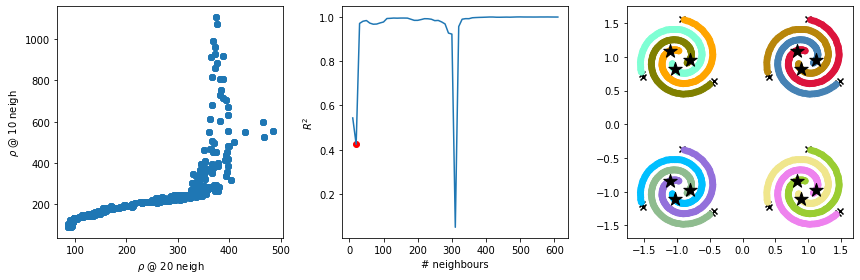

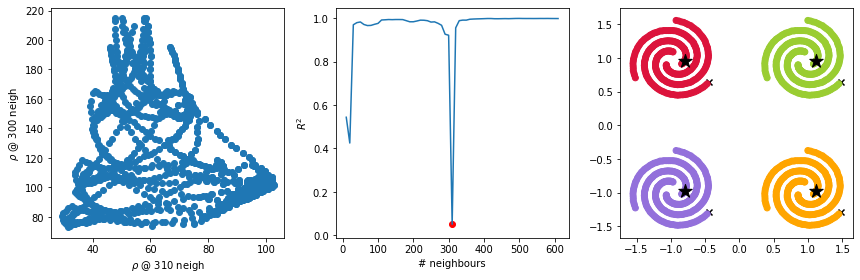

In [21]:
# Load data
with open("examples/spiral_quartet.txt", 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
data = StandardScaler().fit_transform(data)

# Cluster
clone = CLoNe(factor_dc=2, n_resize=2)
clone.fit_hierarchy(data)

# Plot hierarchies
for hier in range(len(clone.gnt_)):
    mplot.figure(figsize=(16,4))
    
    # Plot density interval for current hierarchy
    mplot.subplot(141)
    mplot.scatter(clone.neigh_density_[:, clone.gnt_idx_[hier]+1], clone.neigh_density_[:, clone.gnt_idx_[hier]])
    mplot.xlabel(r"$\rho$ @ %i neigh"%(clone.neighbour_interval_*(clone.gnt_idx_[hier]+1)))
    mplot.ylabel(r"$\rho$ @ %i neigh"%(clone.neighbour_interval_*clone.gnt_idx_[hier]))

    # Plot R2 with current gnt
    mplot.subplot(142)
    n_intervals = len(clone.r2_)
    intervals = np.arange(1, n_intervals+1) * clone.neighbour_interval_
    mplot.plot(intervals, clone.r2_)
    mplot.scatter(clone.gnt_[hier], clone.r2_[clone.gnt_idx_[hier]], marker='o', c='red' )
    mplot.xlabel("# neighbours")
    mplot.ylabel(r"$R^{2}$")
    
    # Plot cluster labels
    mplot.subplot(143)
    # Mask for real cluster labels (!=-1) and outliers (==-1)
    assigned_mask = np.where(clone.labels_[hier] != -1)
    outliers_mask = np.where(clone.labels_[hier] == -1)

    mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x')
    mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[hier][assigned_mask]])
    mplot.scatter(data[clone.centers_[hier],0], data[clone.centers_[hier],1], c='black', marker='*', s=200)
    mplot.tight_layout()
    
mplot.show()